<h1 style="color:purple"> SA&P </h1>
<h4 style="color:purple"> Serie A Analysis and Prediction </h4> 

#### Lorenzo Didomenico

##### *Instagram: @lorydidomenic*
##### *Github: lorenzodidomenic*
##### *Palazzolo Acreide, SR*


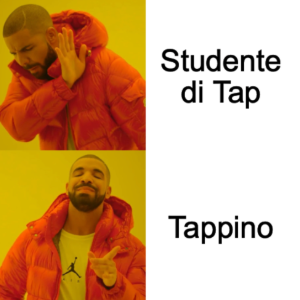

<span> <b> SA&P <br> </spn> <br>
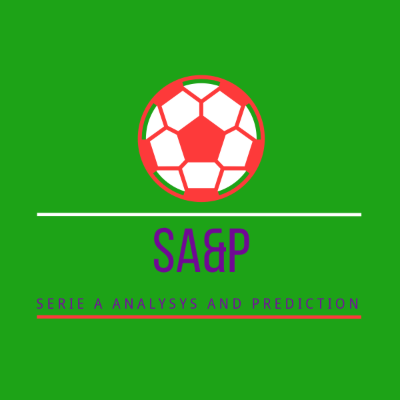
<br>
[SA&P project](https://github.com/lorenzodidomenic/AllAboutFootball)

 Questo progetto analizza le statistiche dei club di Serie A dal 2011 al 2024 per poter analizzare e predire la posizione in classifica sulla base di determinati dati

La posizione in classifica di un club in una determinata stagione dipende infatti da fattori: 
-   Partite Vinte 
-   Partite Perse 
-   Partite Pareggiate 
-   Punti Fatti 
-   Goal Fatti
-   Goal Subiti


 A partire da questi parametri possiamo quindi predire la posizione in classifica di un determinato club.

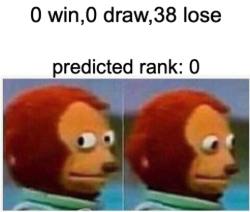


L'applicazione sarà in grado di: 
-  Analizzare le classifiche attese e confrontarle con le classifiche effettive per gli anni passati 
-  Simulare il posizionamento in classifica in una stagione di un determinato club a partire da determinate statistiche
- Simulare una classifica in una determinata stagione a partire da dati randomici 

## Road map

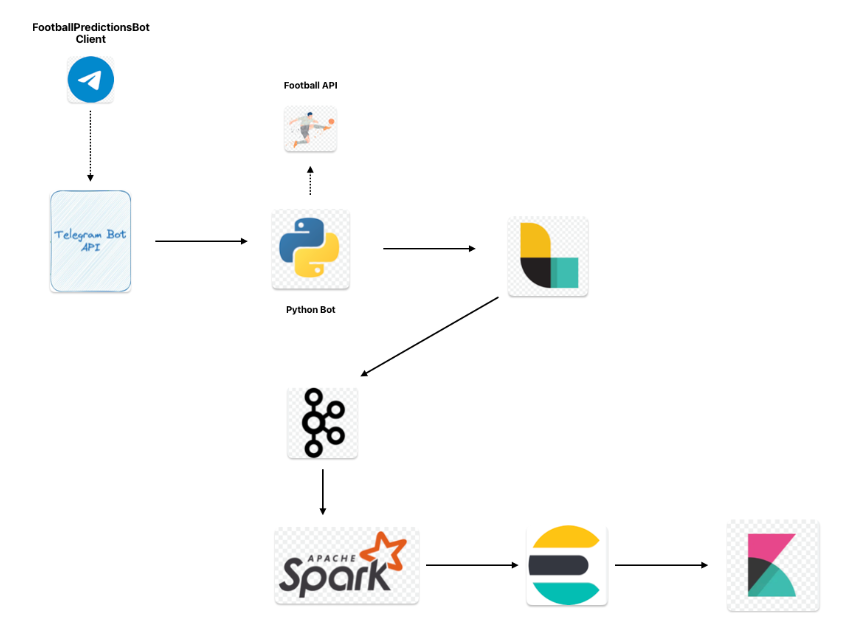

#### Fase 1 
L'applicazione parte con una comunicazione tra il bot Telegram e lo script python , grazie alle **Telegram Bot Api**.

L'utente può mandare un determinato comando alla applicazione in base alle sue esigenze

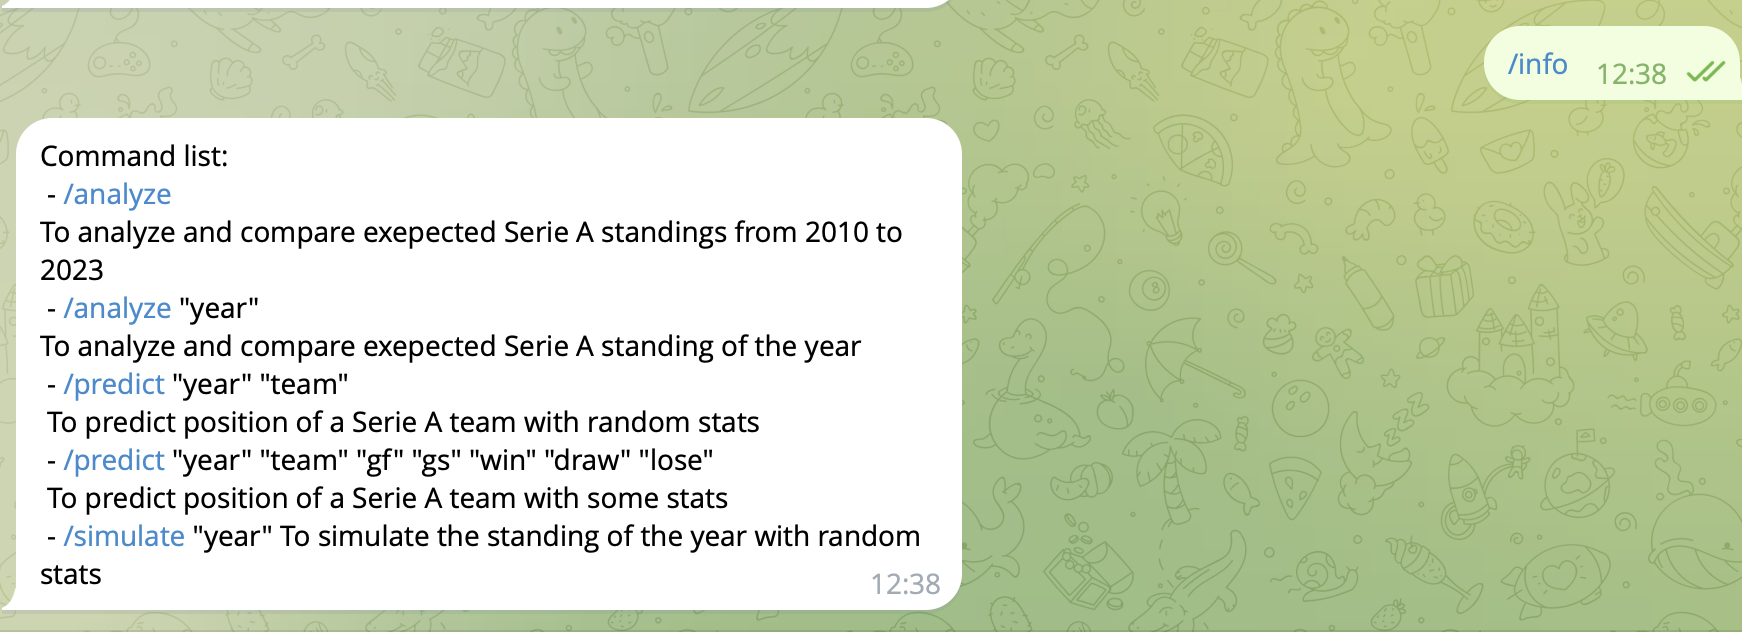

###### [Telegram bot](https://github.com/lorenzodidomenic/AllAboutFootball/tree/main/docker_bot)


Nel caso di una richiesta di tipo **/analyze** in breve lo script richiederà i dati alla sorgente. 

In [ ]:
#...see the code

#the url is an env variable of the container where run the bot
#the id is the id of the league that Api expect
url = str(os.environ["URL"])+"league="+str(id)+"&season="+str(i) 
response = requests.request("GET", url, headers=headers, data=payload)
json_object = json.loads(response.text)  # i create a json object from the response

Nel caso di una richiesta di tipo **/predict** o **/simulate** lo script genererà un json inizializzando i campi o con valori randomici o con quelli passati dall'utente

In [ ]:
#user defined function that generate a text with required format
response = generate_json(year,team,points,win,draw,lose,gol_for,gol_against)
json_object = json.loads(response)  # i create a json object from the response created

Lo script python ottenuti i dati li invia a Logstash. In particolare invierà un json contenente le statistiche ottenute.

In [ ]:
#logstash is the container name of the container with logstash
r = requests.request("POST",url="http://logstash:8080",json=json_object)  

#### Fase 2 
**Logstash**  pulirà il dato che gli arriva eliminando tutti i campi che non sono utili ( grazie ai *filter* ) a **Spark** nell'analisi dei dati. 
Dopo aver 'pulito' il dato lo manda sul topic SerieA creato all'interno di **Kafka** 

In [ ]:

#riceve i dati mandati dallo script python alla porta 8080
input{
     http{
        port => 8080
    }
}

#filter , see the code ...

#scrive il dato su un topic di kafka
output {
  kafka {
    codec => json
    topic_id => "topicSerieA"
    bootstrap_servers => "kafkaServer:9092"
  }
}


###### [Logstash](https://github.com/lorenzodidomenic/AllAboutFootball/tree/main/docker_logstash) 


Possiamo vedere come il dato che arriva sul topic sia ripulito rispetto al dato iniziale grazie al lavoro di **Logstash**

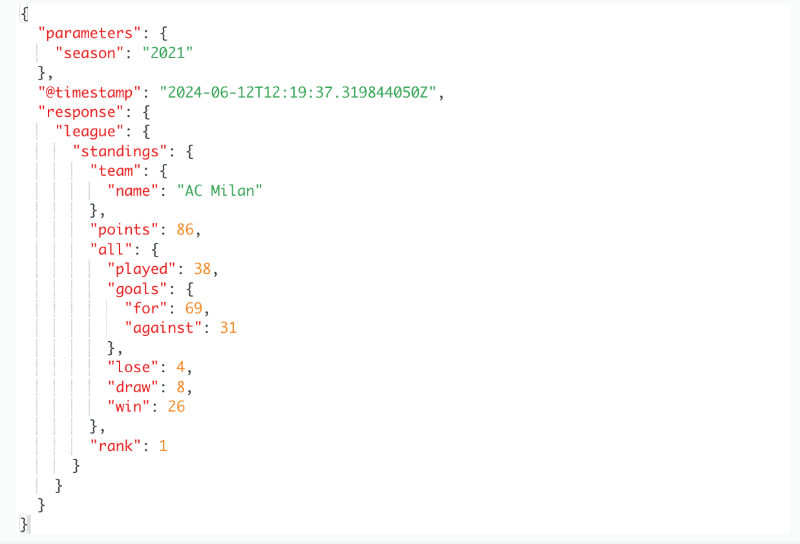

#### Fase 3 
Il cuore della nostra applicazione. In questa l'applicazione utilizza il modello allenato sulle statistiche della serie A dal 2005 al 2023 per analizzare il dato richiesto dall'utente e predire tramite la **Regressione Lineare** il valore atteso del ranking in base ai dati arrivati. 

##### [data](https://github.com/lorenzodidomenic/AllAboutFootball/blob/main/docker_spark/dataset/data.csv)

##### **Fase 3.1**
Alleniamo il modello passando a spark il nostro script di training. Esso in particolare legge uno storico dei dati da un file csv  e lo traina con la Regressione Lineare: 

In [ ]:
training = spark.read.format("csv").options(header='true',inferschema='true',delimiter=",").load("/tmp/data.csv")
featureassembler = VectorAssembler(inputCols = ["points","for","against","win","draw","lose"],outputCol = "features") #definisco le colonne che saranno i parametri della predizione
lr = LinearRegression(featuresCol="features",labelCol="rank",predictionCol="Predicted_rank")
pipeline = Pipeline(stages=[featureassembler,lr])
model = pipeline.fit(training)

##### [Trainer Script](https://github.com/lorenzodidomenic/AllAboutFootball/tree/main/docker_spark/trainer.py)

Attraverso alcune righe di codice possiamo anche valutare l'*RMSE* (*Root Mean Squared Error*) che ci misura la deviazione standard dei residui, ovvero quanto in media si distanziano dai valori effettivi. 
Otteniamo un valore *0.07*, molto basso, che ci indica che il modello è affidabile

Questo modello lo salviamo all'interno di un volume condiviso che abbiamo montato al container. 

Salvandolo possiamo caricarlo ed utilizzarlo quando vogliamo

In [ ]:
model.save("/tmp/footbAllVolume/Completemodel") 

##### **Fase 3.2**
La fase cruciale della nostra applicazione. All'avvio dell'applicazione passiamo a spark-submit il nostro script in pyspark. 
Questo script crea un Datastream con i dati richiesti ogni volta dall'utente e arrivati sul topic Kafka. 

In [ ]:
#mi leggo lo stream da kafka
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", kafkaServer) \
  .option("failOnDataLoss", False)\
  .option("subscribe", topic) \
  .load()

##### [PySpark Script](https://github.com/lorenzodidomenic/AllAboutFootball/tree/main/docker_spark/sparkApplication.py)


Su questi dati ne crea una struttura e passa il dato al modello pre-addestrato.  
Esso a partire dai dati arrivati calcola un *Predicted Rank*. Il *Predicted Rank* potrebbe essere un numero negativo o superiore alla massima posizione possibile. Per evitare questo uso una UDF function per settare minimo e massimo valore predetto (Prima Posizione o Ultima Posizione)

In [ ]:
#....see the code to view the structure building

model = PipelineModel.load(modelPath)  #carico il modello

def map_(x):
    if x <= 0: 
      x =1.0 
    elif x >= 20:
      x= 20.0
    return x
map_udf = udf(map_,FloatType())    #la trasformo in udf function

predictDf = model.transform(parseDf).select('@timestamp','name','season','rank','Predicted_rank',"for","against","win","draw","lose")
predictDf = predictDf.withColumn("Predicted_rank",map_udf("Predicted_rank"))

Ogni volta che arriva il dato e l'ho quindi processato lo mando ad *ElasticSearch*

In [ ]:
#mando ad elastic
predictDf.writeStream \
   .option("checkpointLocation", "/tmp/") \
   .format("es") \
   .start(elastic_index) \
   .awaitTermination()

#### Fase 4 
La fase finale della nostra applicazione e la più "visibile". I dati arrivano ad **Elastic** in un unico indice 'football' e grazie a **Kibana** l'applicazione fa un confronto fra l'effettiva classifica di Serie A in una determinata stagione e quella predetta dal modello sui dati che gli arrivano. 

## Let's go...

Lanciamo la nostra applicazione

In [ ]:
#dalla cartella del progetto 

docker compose -f footbAll.yml  up

Lanciati i nostri container importiamo le nostre Dashboard su Kibana per avere una visualizzazione concreta dei dati che arrivano

##### [Kibana Setup](http://localhost:5601/app/management/kibana/objects)

Possiamo adesso inviare istruzioni al bot dal canale telegram 

##### [FootballPredictionBot](https://t.me/footbalpredictions_bot)

Attraverso il comando **/info** il bot ci risponde con la lista di tutte i comandi possibili 

#### Analisi 

Possiamo ad esempio richiedere la classifica  attesa per il campionato appena concluso 

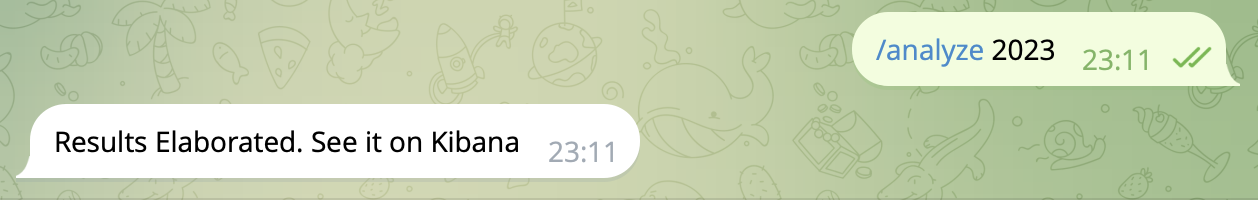

Ed ottenere un confronto con la classifica effettiva 

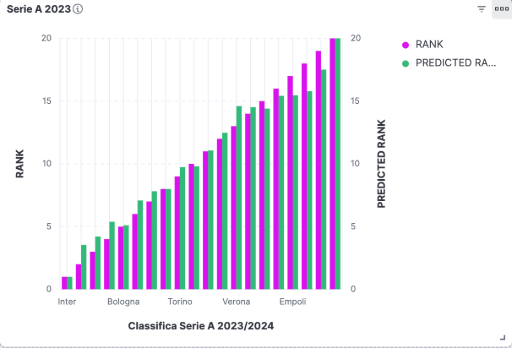

Notiamo che il valore previsto in base alle statistiche delle Squadre e il posizionamento effettivo in classifica sia molto vicino. 

Possiamo richiedere un confronto tra le classifiche attese e le classifiche effettive della Serie A dalla stagione 2011 alla stagione 2024

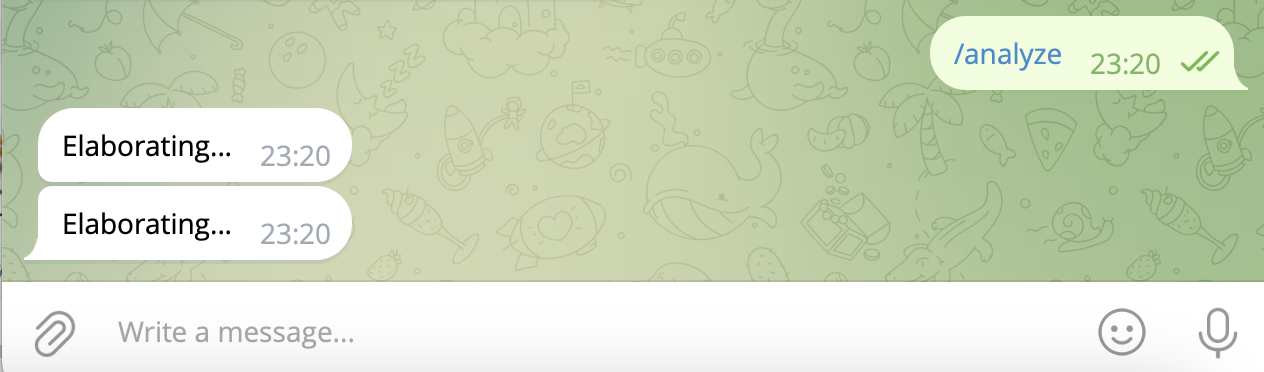

Su Kibana andiamo a vedere passo passo l'arrivo dei dati che vengono elaborati. 


Un grafico abbastanza esplicativo su Kibana ci dimostra l'accuratezza del modello costruito, confrontando per tutte le squadre e gli anni analizzati la media dei *rank* e dei *predicted_rank* 

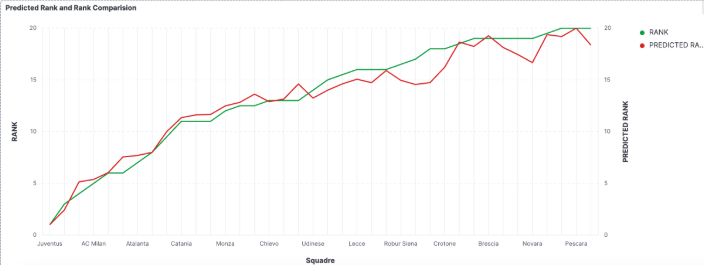

#### Prediction

Possiamo richiedere alla nostra applicazione di prevedere la posizione di una squadra in un determinato anno con particolari statistiche o con statistiche randomiche. 

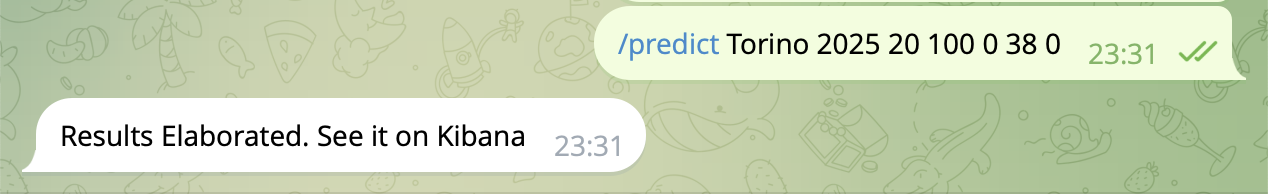

E come possiamo immaginare: 

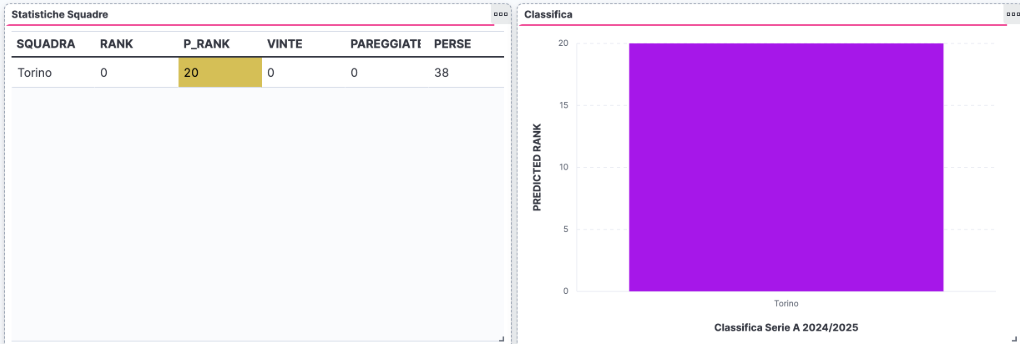

Se vogliamo simulare statistiche random per ogni club in una determinata stagione , otteniamo classifiche fantasiose

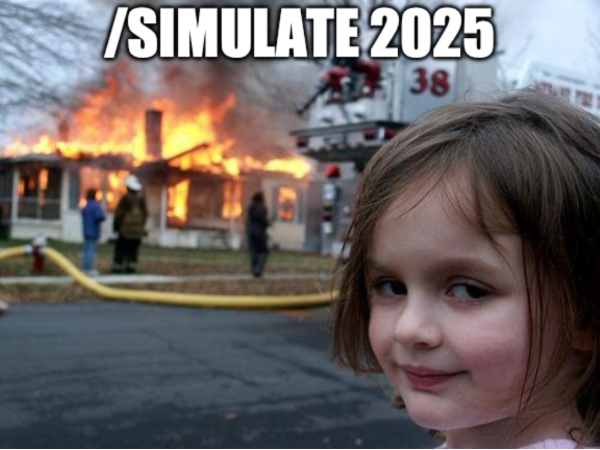

## Tecnologie utilizzate 

### Telegram bot

Utilizzo un bot telegram per avere un interfaccia semplice con il quale l'utente può interagire e dare istruzioni all'applicazione
##### [FootballPredictionBot](https://t.me/footbalpredictions_bot)

La piattaforma di messagistica telegram mi permette di creare un bot che legga i messaggi che un utente invia al Telegram server grazie alle **Telegram Bot Api**.
In particolare l'applicazione python potrà accedere alle Api grazie ad un token ottenuto in fase di generazione del Bot<br>L'applicazione si mette in ascolto e all'arrivo di un determinato messaggio da parte dell'utente eseguirà una determinata funzione

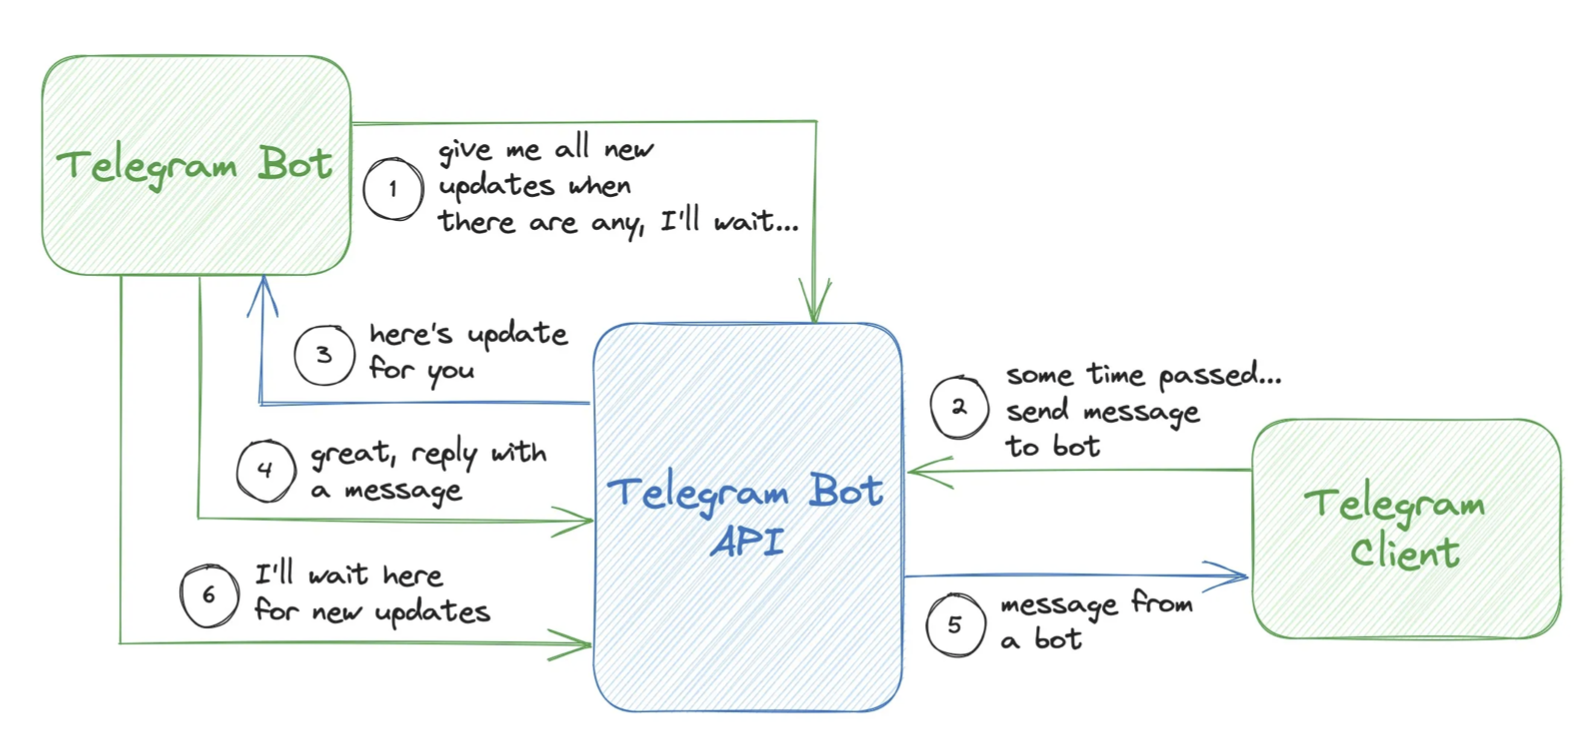

In questo modo riusciamo a gestire quindi la pipeline: 
- Utente manda un messaggio al Server Telegram 
- Il bot in ascolto sulle Api viene avvisato dell'arrivo del messaggio 
- Il bot in base al messaggio dell'utente richiede i dati alle *Api-Football*.
- Poi manda i Dati a *Logstash* e il dato continua il suo viaggio 


### Logstash 

Uso l'immagine ufficiale di Logstash rilasciata da elastic.<br>Utilizzo logstash perchè grazie alla funzionalità *filter* mi permette di rimuovere tutti i campi inutili che mi arrivano nel dato dalle API e di trasformare il dato grezzo in un dato più pulito

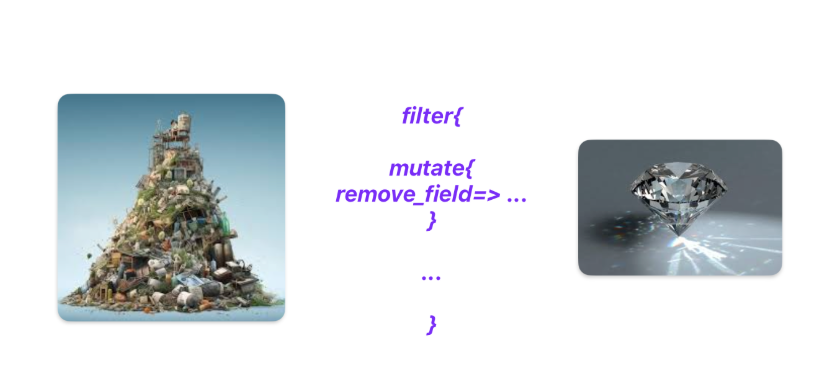

### Kafka 
Utilizzo l'immagine di Confluent per Kafka sfruttando anche un container con Zookeper.

In kafka mi creo un unico topic *Topic Serie A*

Abbiamo creato il topic lanciando un container Kafka con entrypoint l'eseguibile per la creazione del topic.

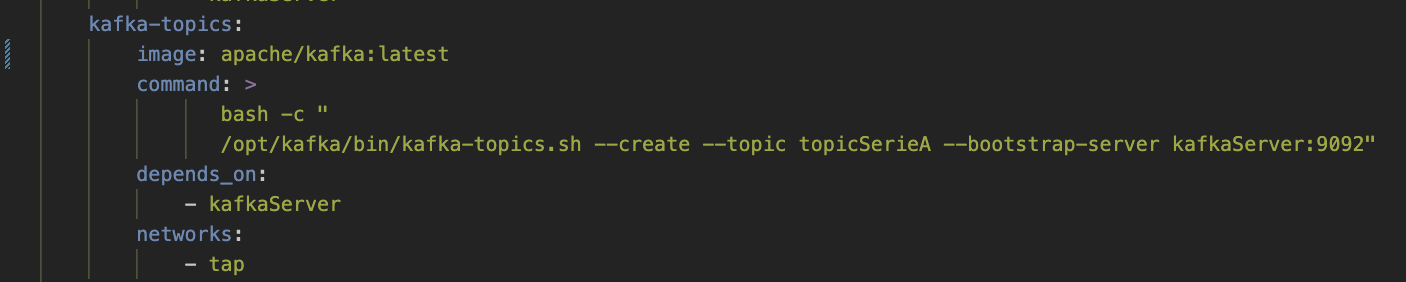

###### [Football.yml ](https://github.com/lorenzodidomenic/AllAboutFootball/blob/main/footbAll.yml)

### Spark 

Utilizzo l'immagine ufficilae di Spark versione *3.4.2* per garantire la compatibibilità con *Elastic Search*


Utilizzo la libreria di machine learning *Spark MLib* per poter trainare il modello per la  *Regressione Lineare* sui miei dati.
###### [Trainer](https://github.com/lorenzodidomenic/AllAboutFootball/tree/main/docker_spark/trainer.py)




Utilizzo la libreria *Spark Sql* per creare la struttura del DataStream continuamente aggiornato con i dati arrivati

La libreria *SparkMLib* mi permette di utilizzare il modello sui dati e quindi poterne applicare la *Pipeline* creata per predire i risultati futuri 

###### [SparkApplication](https://github.com/lorenzodidomenic/AllAboutFootball/tree/main/docker_spark/sparkApplication.py)

### Elastic Search and Kibana 

Utilizzo l'immmagine ufficiale di *ElasticSearch<* e di *Kibana*

In **Elastic Search** creo un unico indice *football* per i documenti che gli arrivano da **Spark**. Questo mi permette di ottimizzare le ricerche.

**Kibana** mi permette di avere un'interfaccia grafica moderna e di utilizzare grafici  sui dati arrivati su **ElasticSearch** , utilizzando delle Dashboard. 


## The end 